<a href="https://colab.research.google.com/github/BiancaHill/Data-Science/blob/main/BianHillU7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 7 Project: Polynomials, Splines, and GPs, Oh my!

**Task**:

Two parts:

1. Propose a data set that's compatible with pymc and/or bambi. I must approve your submission before you move on to part 2.

2. Create, analyze, and present any guassian process or approximate GP, degenerate or otherwise (this means glms and b splines are allowed), using pymc within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is), or if must be an actual GP
  - You must document and explain your model selection method. This means you must argue that your model choice (glm, b spline, GP) is better than at least one other choice. You may use either a theoretical or numerical argument.



For this project, I decided to attempt to predict market/open price for DJIA stocks based off of its price over the years. My mom is a financial advisor and we just started learning about the market crash of the Great Depression so this topic seemed very fitting.

I'm attempting a Gaussian Process as they typically work well for time series which this is. Plus, they're super interesting and I want to see if I can do it.

# GP Model

In [1]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

!pip install preliz
import preliz as pz
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-5rvja7ug
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-5rvja7ug
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=dc84532ec4430cf5d9c8eec52664baa0b7919d337dd60d504201f28567f043f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-o0v3h53j/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 4.6 MB/s eta 0:00:00
   ━

In [2]:
import pymc as pm

In [3]:
DJIA = pd.read_csv('https://raw.githubusercontent.com/BiancaHill/Data-Science/refs/heads/main/AABA_2006-01-01_to_2018-01-01.csv')
DJIA

Date   Open   High    Low  Close    Volume  Name
0     2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
1     2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2     2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
3     2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
4     2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA
...          ...    ...    ...    ...    ...       ...   ...
3014  2017-12-22  71.42  71.87  71.22  71.58  10979165  AABA
3015  2017-12-26  70.94  71.39  69.63  69.86   8542802  AABA
3016  2017-12-27  69.77  70.49  69.69  70.06   6345124  AABA
3017  2017-12-28  70.12  70.32  69.51  69.82   7556877  AABA
3018  2017-12-29  69.79  70.13  69.43  69.85   6613070  AABA

[3019 rows x 7 columns]

Baseline plot of what the data looks like by itself just to get a better idea of the data from the visualization.

<Axes: xlabel='Date', ylabel='Open'>

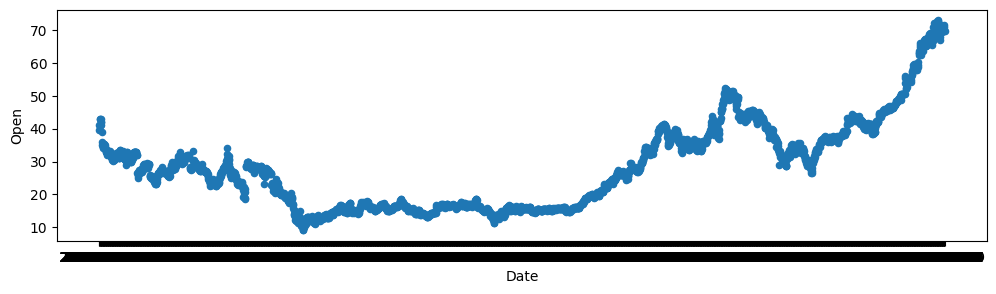

In [4]:
DJIA.plot(x="Date", y="Open", figsize=(12, 3), kind="scatter")

My date data was originally in dash form, so for example 03-02-2025, which the model couldn't really run with. So, here I'm changing those dates to arbitrary integers that represent some data. I don't really know how that works since I found it on the internet, but I'm pretty sure it's using the to_datetime function to change it to an integer by I think dividing it by 10^9.

I also have a bunch of different forms of the converted Date column as different sections of the model needed it in different forms.

In [5]:
date = pd.to_datetime(DJIA['Date']).astype(int)/ 10**9
DJIA['Date'] = pd.to_datetime(DJIA['Date']).astype(int)/ 10**9
date2 = pd.to_datetime(DJIA['Date']).astype(int)/ 10**9
print(date)

0       1.136246e+09
1       1.136333e+09
2       1.136419e+09
3       1.136506e+09
4       1.136765e+09
            ...     
3014    1.513901e+09
3015    1.514246e+09
3016    1.514333e+09
3017    1.514419e+09
3018    1.514506e+09
Name: Date, Length: 3019, dtype: float64


Turning date into a numpy array

In [6]:
date = date.values[:,None]

Setting up a weakly informative prior for the smoothness parameter ℓ (controls how wiggly the line our GP creates will be)

In [7]:
#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

Actual GP model

In [8]:
with pm.Model() as model_L:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(date))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=date)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.Normal("y", np.exp(f), α, observed=DJIA.Open)

    idata_L = pm.sample()

Output()

Mean of the model

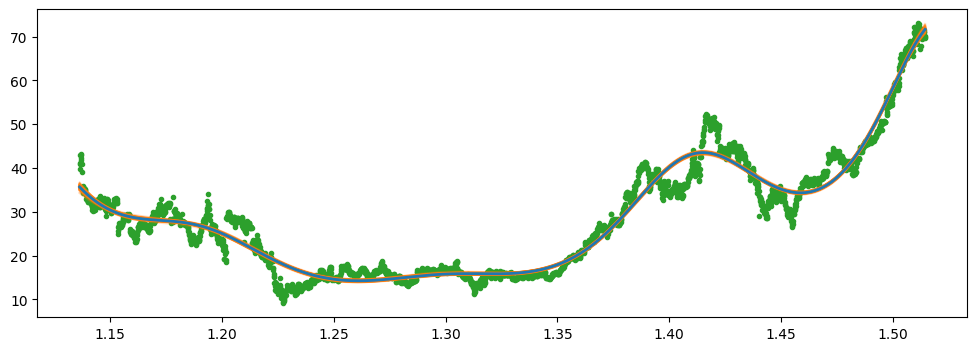

In [9]:
#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(date2, DJIA["Open"].values, "C2.")

#grab posterior
f = az.extract(idata_L, group="posterior", var_names="f")


idx = np.argsort(date2)
#plot samples of the posterior
ax.plot(date2[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
#plot posterior mean
ax.plot(date2[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

Based off of the mean line of the posterior, I'm assuming most of the things that are supposed to be happening with the posterior are happening since it looks really good. However, the mean of the posterior isn't actually that helpful for analysing since we can't see the error bars and spefics of the model given by the posterior predictive check. The mean of the posterior makes it so we can't see if there's something wrong going on that's getting covered up by other things going wrong that's balancing it out.

Here is my crazy attempts at getting a posterior predictive check to run which ended really badly and you should ignore it. If you're interested, feel free to take a look but it's not going to actually tell you anything helpful.

# Posterior Predictive Check Attempt

In [ ]:
fidx = f.values[idx]
fidx

array([[3.59242835, 3.60302904, 3.59472471, ..., 3.58766627, 3.58962968,
        3.570625  ],
       [3.59091892, 3.60148512, 3.59323807, ..., 3.58630909, 3.5882633 ,
        3.56934023],
       [3.58941336, 3.59994495, 3.59175496, ..., 3.58495512, 3.58690012,
        3.56805836],
       ...,
       [4.27287125, 4.27491915, 4.26916585, ..., 4.25835326, 4.2639152 ,
        4.28343773],
       [4.27363604, 4.27567624, 4.26989716, ..., 4.25906659, 4.26462032,
        4.28432096],
       [4.2743932 , 4.2764257 , 4.27062077, ..., 4.25977245, 4.26531782,
        4.28519712]])

In [ ]:
with model_L:
    posterior_predictive = pm.sample_posterior_predictive(idata_L)

Output()

In [ ]:
print(posterior_predictive.keys())

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


In [12]:
print(idata_L.keys())

KeysView(Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data)


In [ ]:
print(posterior_predictive.posterior_predictive)

<xarray.Dataset> Size: 48MB
Dimensions:  (chain: 2, draw: 1000, y_dim_2: 3019)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * y_dim_2  (y_dim_2) int64 24kB 0 1 2 3 4 5 ... 3013 3014 3015 3016 3017 3018
Data variables:
    y        (chain, draw, y_dim_2) float64 48MB 34.39 38.81 ... 75.49 74.72
Attributes:
    created_at:                 2025-03-02T20:10:43.111058+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1


KeyError: "None of [Index([(1136246400.0,), (1136332800.0,), (1136419200.0,), (1136505600.0,),\n       (1136764800.0,), (1136851200.0,), (1136937600.0,), (1137024000.0,),\n       (1137110400.0,), (1137456000.0,),\n       ...\n       (1513296000.0,), (1513555200.0,), (1513641600.0,), (1513728000.0,),\n       (1513814400.0,), (1513900800.0,), (1514246400.0,), (1514332800.0,),\n       (1514419200.0,), (1514505600.0,)],\n      dtype='object', length=3019)] are in the [columns]"

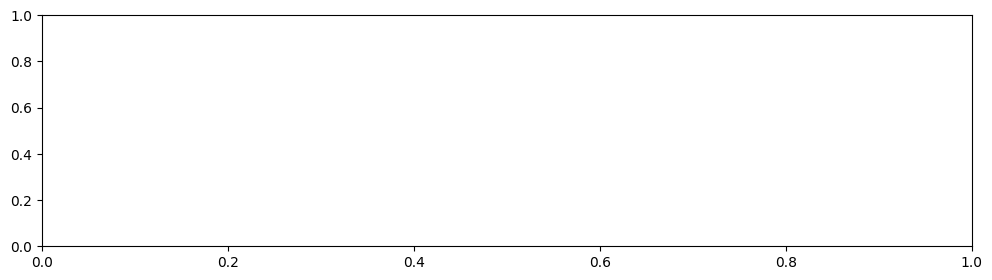

In [ ]:
DJIA.plot(x=date, y="Open", figsize=(12, 3), kind="scatter")

In [ ]:
price = DJIA["Open"].values
date3 = DJIA["Date"].values[:,None]

In [ ]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(date3))
}

priors = {
    "hsgp(date3, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_O = bmb.Model("Open ~ 0 + hsgp(date3, m=10, c=1.5)", DJIA, priors=priors)
idata_O = model_O.fit()

Output()

AttributeError: 'Model' object has no attribute 'posterior'

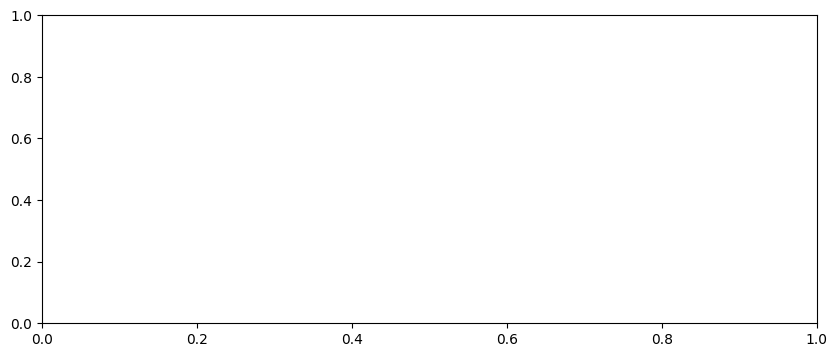

In [ ]:
y_preds = posterior_predictive.posterior_predictive['y']

fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f = az.extract(model_O.posterior.sel(draw=slice(None, None, 10)), var_names="f")
y_preds = az.extract(model_O.posterior_predictive.sel(draw=slice(None, None, 10)), var_names="Date")

ax.plot(DJIA['Open'], date3, color="#AAC4E6", alpha=0.02)
ax.plot(DJIA['Open'], f, color="#70133A", alpha=0.1)
ax.scatter(DJIA['Open'], date3, marker="o", color="grey", s=15, label="Date")

ax.set(title="DJIA Stock", xlabel="x", ylabel="y")
ax.legend(frameon=True, fontsize=11, ncol=2);

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


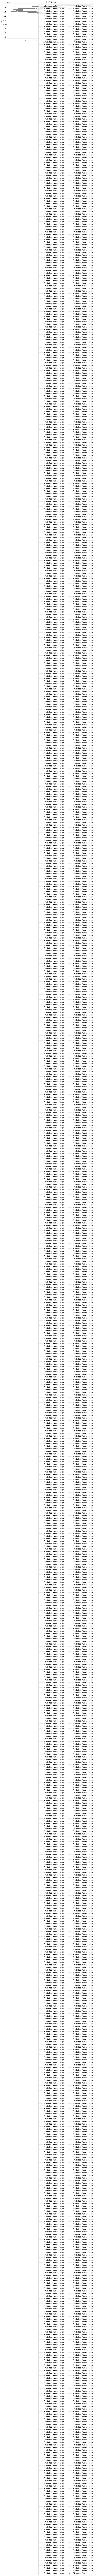

In [ ]:
hsgp_preds = az.extract(idata_O.posterior, var_names="hsgp(date3, m=10, c=1.5)")

# Plotting
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# Plot observed data
ax.plot(DJIA['Open'], DJIA['Date'], color="#AAC4E6", alpha=0.02, label="Observed Data")

# Plot the predicted values from the Gaussian Process (hsgp)
ax.plot(DJIA['Open'], hsgp_preds, color="#70133A", alpha=0.1, label="Predicted Values (hsgp)")

# Scatter the observed data points
ax.scatter(DJIA['Open'], DJIA['Date'], marker="o", color="grey", s=15, label="Observed Points")

# Set labels, title, and legend
ax.set(title="DJIA Stock", xlabel="Stock Open Price (USD)", ylabel="Date")
ax.legend(frameon=True, fontsize=11, ncol=2)

# Show plot
plt.show()

In [ ]:
idata_O = model_O.fit()
print(idata_O)

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


In [ ]:
posterior = idata_O.posterior

In [ ]:
print(idata_O.posterior)

<xarray.Dataset> Size: 49MB
Dimensions:                               (chain: 2, draw: 1000, __obs__: 3019,
                                           hsgp(date3, m=10, c=1.5)_weights_dim: 10)
Coordinates:
  * chain                                 (chain) int64 16B 0 1
  * draw                                  (draw) int64 8kB 0 1 2 ... 997 998 999
  * __obs__                               (__obs__) int64 24kB 0 1 ... 3017 3018
  * hsgp(date3, m=10, c=1.5)_weights_dim  (hsgp(date3, m=10, c=1.5)_weights_dim) int64 80B ...
Data variables:
    hsgp(date3, m=10, c=1.5)              (chain, draw, __obs__) float64 48MB ...
    hsgp(date3, m=10, c=1.5)_ell          (chain, draw) float64 16kB 4.392e+0...
    hsgp(date3, m=10, c=1.5)_sigma        (chain, draw) float64 16kB 1.372 .....
    hsgp(date3, m=10, c=1.5)_weights      (chain, draw, hsgp(date3, m=10, c=1.5)_weights_dim) float64 160kB ...
    hsgp(date3, m=10, c=1.5)_weights_raw  (chain, draw, hsgp(date3, m=10, c=1.5)_weights_dim) float64

In [ ]:
f = az.extract(posterior.sel(draw=slice(None, None, 10)), var_names="hsgp")
y_preds = az.extract(idata_O.posterior_predictive.sel(draw=slice(None, None, 10)), var_names="y")

KeyError: 'var names: "[\'hsgp\'] are not present" in dataset'

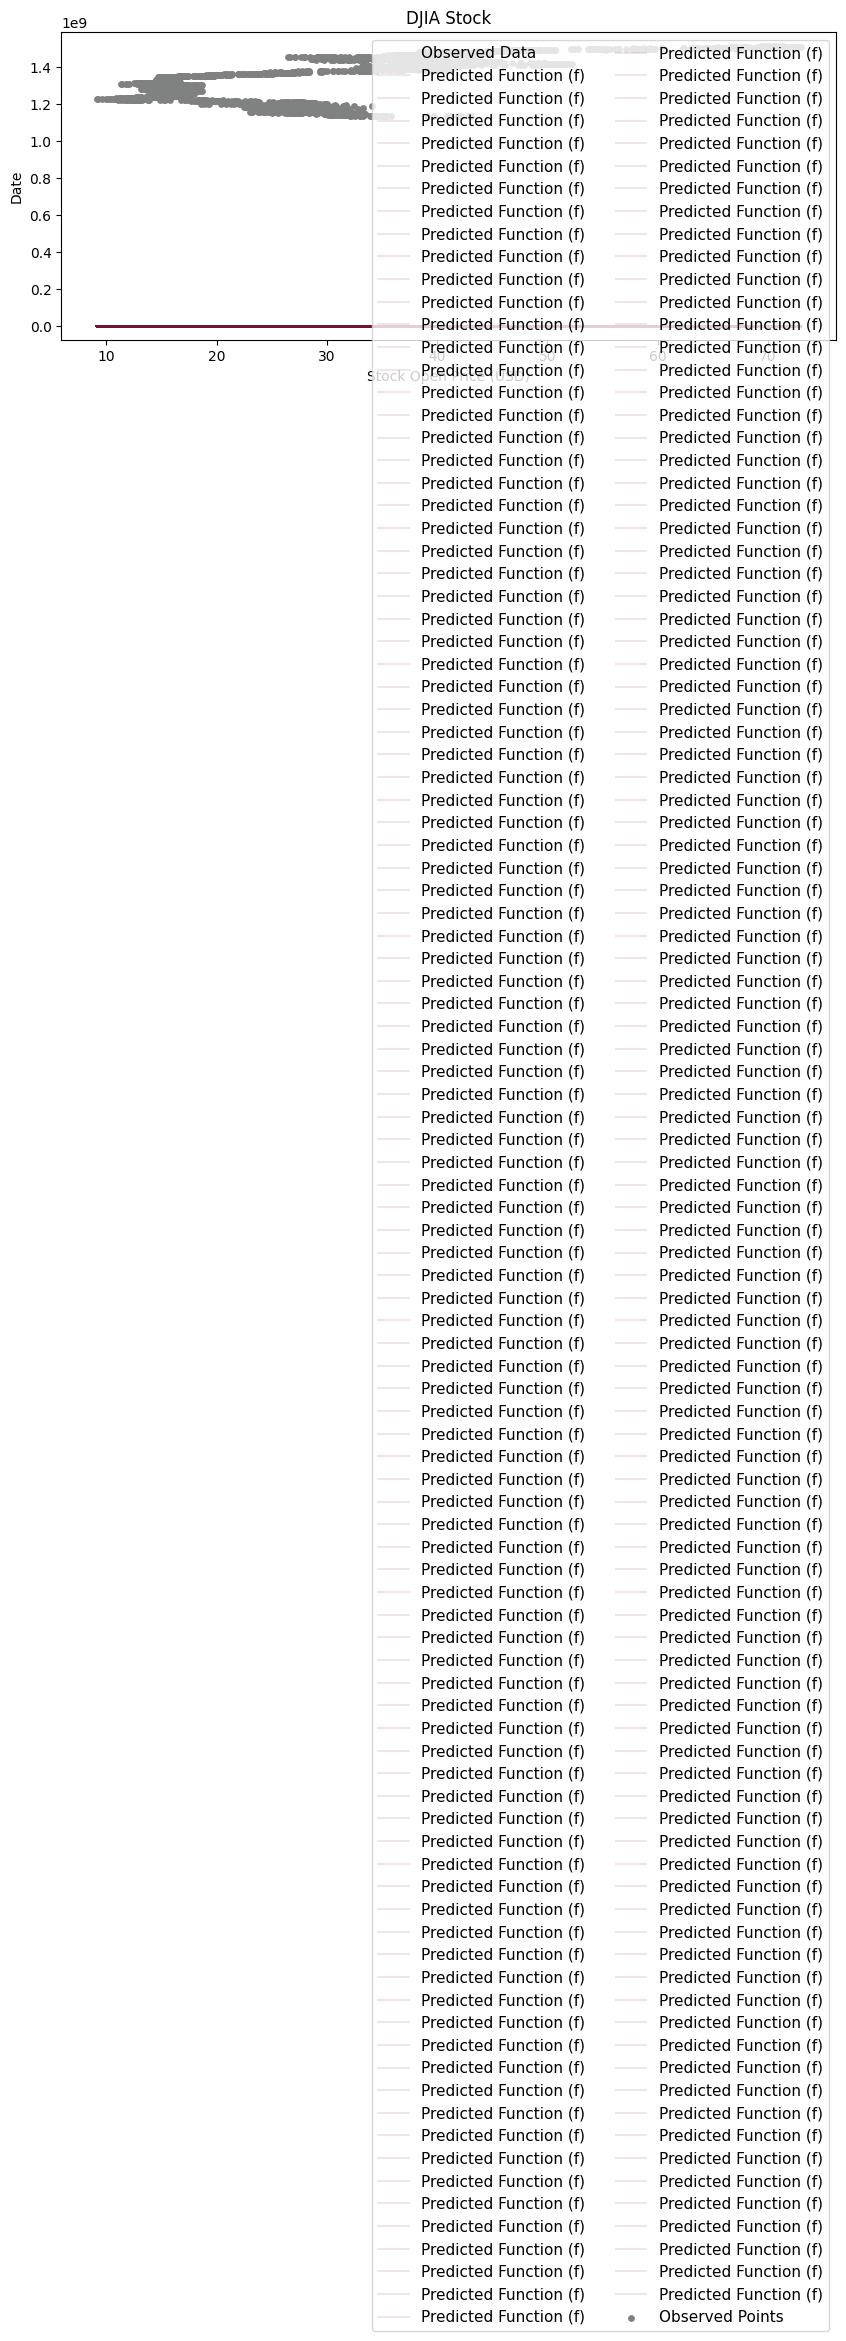

In [ ]:
# Extract posterior samples for predictions
f = az.extract(posterior_predictive.posterior_predictive.sel(draw=slice(None, None, 10)), var_names="y")


# Flatten date3 if necessary
date3 = date3.flatten()

# Plotting
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# Plot observed data
ax.plot(DJIA['Open'], date3, color="#AAC4E6", alpha=0.02, label="Observed Data")

# Plot the predicted function (f) against the observed 'Open'
ax.plot(DJIA['Open'], f, color="#70133A", alpha=0.1, label="Predicted Function (f)")

# Scatter the observed data points
ax.scatter(DJIA['Open'], date3, marker="o", color="grey", s=15, label="Observed Points")

# Set labels, title, and legend
ax.set(title="DJIA Stock", xlabel="Stock Open Price (USD)", ylabel="Date")
ax.legend(frameon=True, fontsize=11, ncol=2)

# Show plot
plt.show()


In [ ]:
model_O

       Formula: Open ~ 0 + hsgp(date3, m=10, c=1.5)
        Family: gaussian
          Link: mu = identity
  Observations: 3019
        Priors: 
    target = mu
        HSGP contributions
            hsgp(date3, m=10, c=1.5)
                cov: ExpQuad
                sigma ~ Gamma(mu: 1.0, sigma: 0.01)
                ell ~ InverseGamma(alpha: 5.8119, beta: 592572851.7989)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 13.255)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
print(idata_O.keys())

KeysView(Inference data with groups:
	> posterior
	> sample_stats
	> observed_data)


In [ ]:
print(idata_O.posterior)

<xarray.Dataset> Size: 49MB
Dimensions:                               (chain: 2, draw: 1000, __obs__: 3019,
                                           hsgp(date3, m=10, c=1.5)_weights_dim: 10)
Coordinates:
  * chain                                 (chain) int64 16B 0 1
  * draw                                  (draw) int64 8kB 0 1 2 ... 997 998 999
  * __obs__                               (__obs__) int64 24kB 0 1 ... 3017 3018
  * hsgp(date3, m=10, c=1.5)_weights_dim  (hsgp(date3, m=10, c=1.5)_weights_dim) int64 80B ...
Data variables:
    hsgp(date3, m=10, c=1.5)              (chain, draw, __obs__) float64 48MB ...
    hsgp(date3, m=10, c=1.5)_ell          (chain, draw) float64 16kB 4.455e+0...
    hsgp(date3, m=10, c=1.5)_sigma        (chain, draw) float64 16kB 1.362 .....
    hsgp(date3, m=10, c=1.5)_weights      (chain, draw, hsgp(date3, m=10, c=1.5)_weights_dim) float64 160kB ...
    hsgp(date3, m=10, c=1.5)_weights_raw  (chain, draw, hsgp(date3, m=10, c=1.5)_weights_dim) float64

# Actual Posterior Predictive Check

I followed along with this model's code (https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html) in order to get my posterior predictive check to run since it wouldn't work in Bambi.

In order to get the posterior predictive check, I had to first sample the posterior predictive of the model since the posterior predictive check model wasn't able to do that within the model.

In [10]:
pm.sample_posterior_predictive(idata_L, model=model_L, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

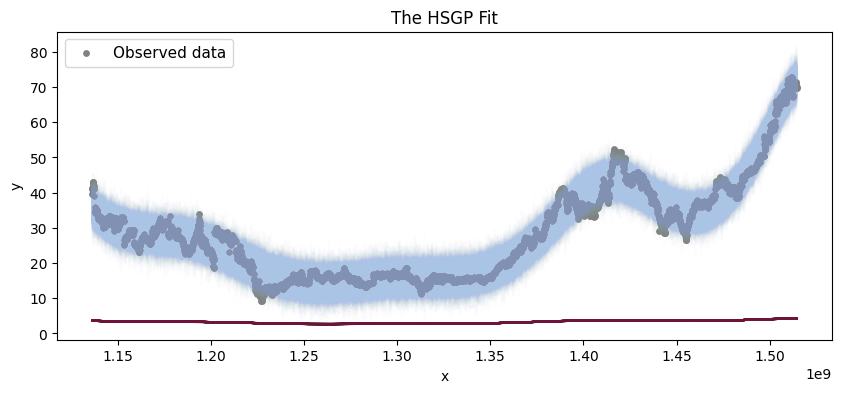

In [11]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f = az.extract(idata_L.posterior.sel(draw=slice(None, None, 10)), var_names="f")
y_preds = az.extract(idata_L.posterior_predictive.sel(draw=slice(None, None, 10)), var_names="y")

ax.plot(date, y_preds, color="#AAC4E6", alpha=0.02)
ax.plot(date, f, color="#70133A", alpha=0.1)
ax.scatter(date, DJIA['Open'], marker="o", color="grey", s=15, label="Observed data")

ax.set(title="The HSGP Fit", xlabel="x", ylabel="y")
ax.legend(frameon=True, fontsize=11, ncol=2);

As you can see, the posterior predictive check worked out very well. The bar covers most if not all of the data points and follows the curves of the observed data. Since I used a gaussian process with time series data, I expected it to work out fairly well. The original data having dashes threw off my model and the work around for that may have lead to some error. Since I had to use like 4 different dates for date, there may have been some inconsistency within the model and might have lead to something going wrong.

Comparing this to my understanding of stocks over the past few years, my model follows reality pretty well. The date region is 2006-2017. So, over on the left the dip was probably the 2008 market crash which took about 6 years to recover which we can see from the increase around x=1.35-1.4. Could my model predict future stock market crashes? Not really. The model can only go off of the data I give it, it's just following trends it finds within the data I have given it. If I created another model that covered the seasonal short term trends I could combine them together and that model might be able to predict crashes but as it stands now, this model cannot predict the future. It's the start of something good but only the start; I'd have to do a lot more work to get it to be something we can actually use as is.

# Comparing to another model

I tried to compare it to both a polynomial and a bspline and I couldn't get either to work. I think it has something to do with having to change the Date column to an integer since it originally had dashes and thats bad. I used the to_datetime function and that changed it to a bunch of integers which then had to be changed to an array to get the GP to run. So, my best guess is theres something in there that's accidently messing it up for a polynomial or a bspline but makes it so that the GP can run.

In [9]:
model_poly_2 = bmb.Model("Open ~ poly(date2, degree=2)", DJIA)
idata_poly_2 = model_poly_2.fit()

Output()

In [14]:
bmb.interpret.plot_predictions(model_poly_2, idata_poly_2, "Date", pps=True)
plt.plot(DJIA['Date'], DJIA['Open'], "C2.", zorder=-3)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 50 and the array at index 1 has size 3019

In [48]:
knots = [1.2,1.45]
model_spline = bmb.Model("Open ~ bs(date2, degree=3, knots=knots)", DJIA)
idata_spline = model_spline.fit()

Output()

In [51]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "Date", pps= True)
plt.plot(date2, DJIA.Open, "C2.", zorder=-3)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 50 and the array at index 1 has size 3019